# *Analytics on Trace Data*

In this notebook we're tying to understand the Trace data, such as basic statistics and stuff. The aim of this notebook in the end is to _collapse the equal-cost multipaths_ or something sround that to reduce the complexity of the data. We here in this notebook look at distributions of data to understand the generalnature of trace data. 

We'll be pulling data from Kibana using the ElasticSearch Python API and plotting some data for easier understanding, we only use the data in production not the test data.


In [85]:
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from time import time, strftime, localtime
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt

#### *Custom Modules*
We use three custom modules which assist us. 

The first module contains various types of queries callable as functions, the second module is a utility module for plotting, getting correct date formats etc.. and the thied module helps us move hops data from Kibana to Neo4j for a source-destination pair.


(The auto-reload extension, always reloads the modules without having the need to restart the IPython Kernel. Helps a lot in development of custom modules like these.)

In [86]:
%load_ext autoreload
%autoreload 2

import Utility_Modules.r_utils as ut
import Utility_Modules.elasticqueries as qrs
import Utility_Modules.kibana_to_neo_pipe as pipe

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### *Conecting to ElasticSearch*
This connection object work throughout the notebook to retreive data from the ElasticSearch Kibana Instance

Enter your user and passwd fields to connect to the database. Change from None to String type

In [87]:
user = None
passwd = None
if user is None and passwd is None:
    with open("creds.key") as f:
        user = f.readline().strip()
        passwd = f.readline().strip()
credentials = (user, passwd)
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'], timeout=90, http_auth=credentials)

print("Connection Successful") if es.ping() == True else print("Connection Unsuccessful")

Connection Successful


------
### *Distinct Counts*

In the next cell we inspect the **count of distinct values** (Fields Specified Below) in the ps trace data in the last 90 day time frame to get some insights on the data.


* dest_host
* src_host
* dest
* src
* dest_site
* src_site

**\***
There is an aditional function present here *__getUniqueCountBy()__* which returns a list of the unique values and not just the length. Although, it prints out the size of the array when executing. It takes in the same argument as the function below.


In [5]:
countOf = ['dest_host', 'dest', 'src_host', 'src','src_site', 'dest_site']
for i in countOf:
    print("{:9s} : {:4d}".format(i, qrs.getUniqueCount(es,'ps_trace',i, ut.getDateFormat(delta=91), ut.getDateFormat())))

dest_host :  268
dest      :  347
src_host  :  206
src       :  260
src_site  :  104
dest_site :  121


### *Looking at the Numbers Above*

**Q :** Why is the number of ip's per site more than 1 (we see upto 7 here)

**A :** "Site" is typically equivalent to a WLCG Tier-2.  Some of our Tier-2s actually are composed of more than one institution.  Each distinct network location (different subnet for example) should have two different perfSONAR toolkits installed; one for latency measurement and one for bandwidth measurement.   A typical "site" at only one institution, should have 2 different IPs; one for latency and one for bandwidth.  A site can have multiple networks to monitor and can therefore have multiple associated IPs

**Q :** Why are there 2 or more ips per hostname

**A :** Some perfSONAR instances have both IPv4 and IPv6 addresses.  This is called being dual-stacked.   That is ONE way to have multiple IP addresses for a specific perfSONAR toolkit instance.   It is also possible to add more IP addresses (which may end up testing different data paths through the network).  Each interface could have additional IP addresses added, either IPv4 or IPv6.  Usually additional IPv4/IPv6 addresses (beyond the first) would be added into specific different VLANs.


**Q :** Why are there more dest_hosts than src_hosts

**A :**

**\*** Thanks **Shawn McKee** for helping answer these questions.

-----
**Frequency Distribution of Source and Destination Hosts **

In [6]:
src_data = qrs.getUniqueCountBy(es,'ps_trace','src_host',ut.getDateFormat(delta=91), ut.getDateFormat())
dest_data = qrs.getUniqueCountBy(es,'ps_trace','dest_host',ut.getDateFormat(delta=91), ut.getDateFormat())

Size : 206
Size : 268


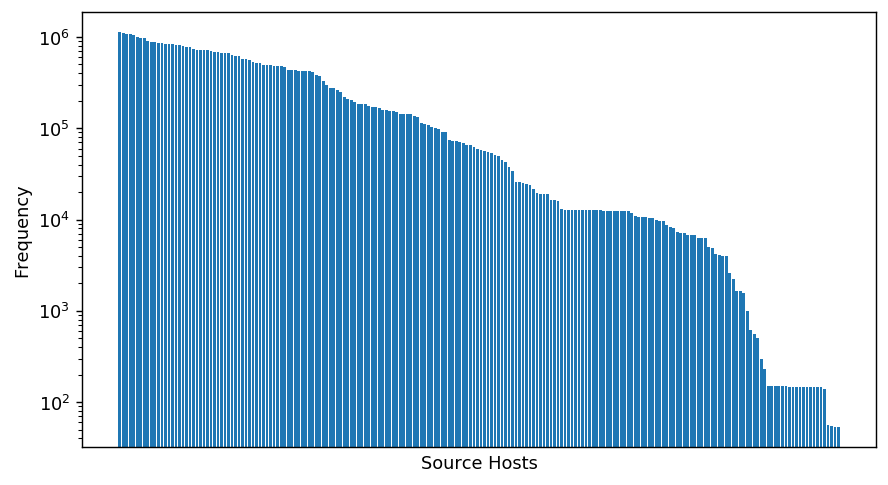

In [7]:
ut.plotByHist(src_data,"Source Hosts",plt)

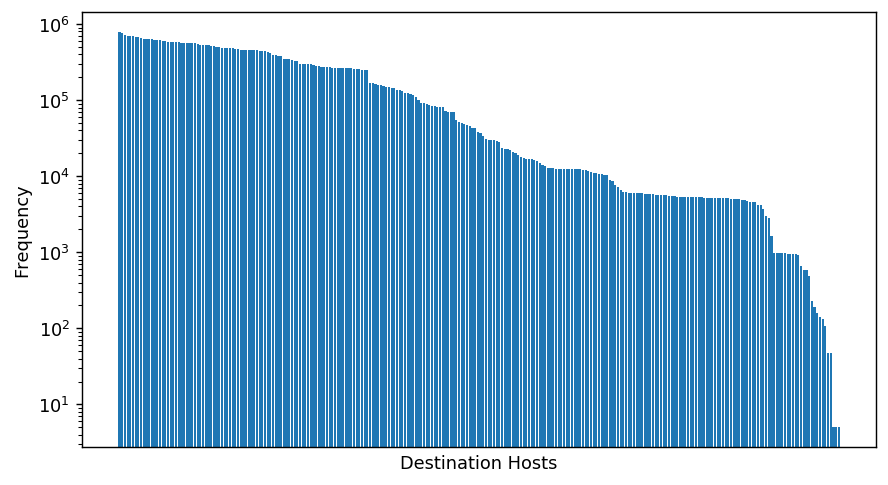

In [9]:
ut.plotByHist(dest_data, 'Destination Hosts', plt)

### *Conclusion*
This helps us see that all the sources do not talk all the destinations and some talk to more than the others. The reason behind this is the mesh architecture. All the hosts present in the mesh talk to every other host in the mest but not outside the mesh. And some nodes are associated with more meshes than others.

-----
### *Frequency Distribution of Paths between all pair of nodes (in the past three months from today)*

We use the results captured another script here for this usecase, which is also placed in the Utility_Modules folder.
That script provides us with two values of our interest, total path between a source and destination and number of paths whihc were take more than once. We did this to reduce the complexity in our data and maybe look it as an alternative to removing equal cost multipaths. 

In [3]:
src_dest_path_df = pd.read_csv("Results/SourceDestinationPairs.csv")
src_dest_path_df.head()

,Source,Destinations,Total,MoreThanOne,Processed,Once
0,202.140.191.90,206.12.9.1,45.0,26.0,1.0,19.0
1,202.140.191.90,109.105.124.88,30.0,19.0,1.0,11.0
2,202.140.191.90,131.154.254.11,47.0,21.0,1.0,26.0
3,202.140.191.90,193.109.172.187,28.0,19.0,1.0,9.0
4,202.140.191.90,193.48.99.77,27.0,13.0,1.0,14.0


#### Distribution of All the Paths

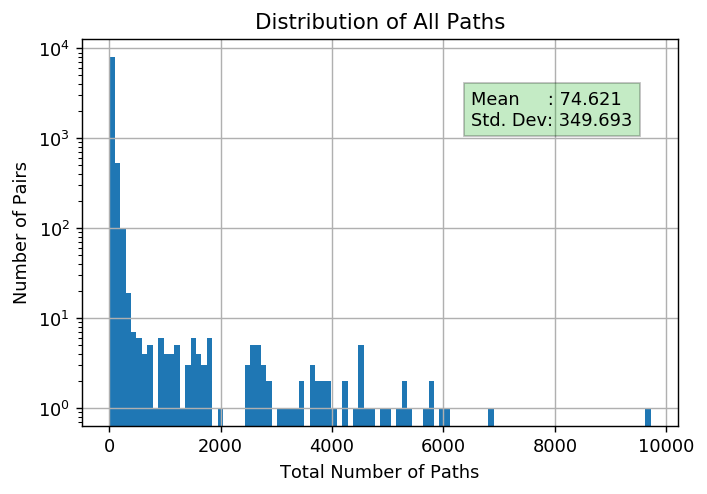

In [4]:
mean_total = src_dest_path_df['Total'].mean()
stddev_total = src_dest_path_df['Total'].std()
legend_data = "Mean     : {:3.3f}\nStd. Dev: {:3.3f}"
plt.figure(dpi=128)
src_dest_path_df['Total'].hist(bins=100)
plt.title('Distribution of All Paths')
plt.xlabel("Total Number of Paths")
plt.ylabel("Number of Pairs")
plt.yscale("log")
props = dict(facecolor='xkcd:green', alpha=0.25)
plt.text(6500, 1400, s=legend_data.format(mean_total, stddev_total), bbox=props);

#### Distribution of Paths taken **more than once**

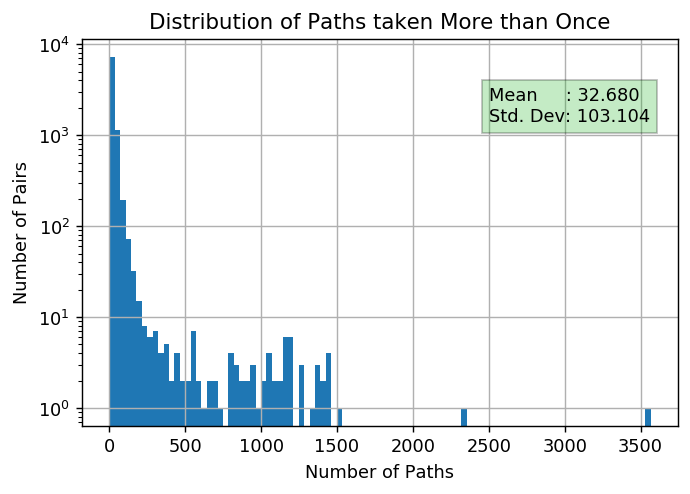

In [5]:
mean = src_dest_path_df['MoreThanOne'].mean()
stddev = src_dest_path_df['MoreThanOne'].std()
legend_data = "Mean     : {:3.3f}\nStd. Dev: {:3.3f}"

plt.figure(dpi=128)
src_dest_path_df['MoreThanOne'].hist(bins=100)
plt.title('Distribution of Paths taken More than Once')
plt.xlabel("Number of Paths")
plt.ylabel("Number of Pairs")
plt.yscale("log")
props = dict(facecolor='xkcd:green', alpha=0.25)
plt.text(2500, 1400, s=legend_data.format(mean, stddev), bbox=props);

### *Conclusion*

As we can see here in the distribution of *all* the paths taken, there are quite a few pairs with paths more than 1500. But if we only look at paths which were taken more than once, we see that there are only 3 pairs (most likely outliers) which have more than 1500 paths. This seems like a very interesting finding and can help us in moving forward.

### *Using Neo4j to further investigate the finding above*

We will now ingest data into a locally hosted Neo4j server, which is a graph database. It also has a nice interface to see the actual graph, which we are most interested in.
To help us with Neo4j we'll use the custom module to move data about the trace hops between a source and destination pair. Which we will randomly sample from all the available pairs.

In [10]:
row = src_dest_path_df.sample(1, random_state=71717)
src = row.iloc[0,0]
dest = row.iloc[0,1]
src, dest

('131.154.254.11', '193.109.172.187')

In [11]:
kibana_usr = None 
kibana_pwd = None
neo_usr = None
neo_pwd = None

with open("creds.key") as f:
    kibana_usr = f.readline().strip()
    kibana_pwd = f.readline().strip()
    neo_usr = f.readline().strip()
    neo_pwd = f.readline().strip()

Connecting to Kibana and Neo4j using Pipeline.

In [18]:
kibana_connect = pipe.KibanaExtractor('atlas-kibana.mwt2.org:9200', kibana_usr, kibana_pwd)
neo_connect = pipe.NeoInjector('bolt://localhost:7687', neo_usr, neo_pwd)

#### Now we prepare data for transfer to Neo4j

* Getting data for the given Source and Destination.
* Getting unique nodes
* Getting Paths and turning them into pairs (A -> B)


In [19]:
kibana_connect.getdata(src, dest)
uniq_nodes = kibana_connect.getuniquenodes()
uniq_paths = kibana_connect.get_paths()

relations = []
for path in uniq_paths:
    for i in range(len(path)-1):
        if path[i] == path[i+1]:
            print(path)
        relations.append((path[i], path[i+1]))
        
print("Path Example: ", uniq_paths[0])
print("Relation Example: ", relations[1], "this means that data flows from IP.1 to IP.2")

Path Example:  ['SOURCE : 131.154.254.11', '131.154.254.1', '193.206.128.169', '192.16.166.154', '192.16.166.153', '192.16.166.58', '193.109.172.187', 'DESTINATION : 193.109.172.187']
Relation Example:  ('131.154.254.1', '193.206.128.169') this means that data flows from IP.1 to IP.2


#### Clearing Neo4j for previous node instances

In [20]:
neo_connect.delete_all()

#### Sending Nodes and Relations to Neo4j

In [21]:
neo_connect.send_nodes_to_neo(uniq_nodes)
neo_connect.send_relations_to_neo(relations)

### Now For Paths taken more than once only

We only have to pass a parameter to the get_paths functon which gets paths taken more than ***k*** number of times

In [25]:
uniq_paths = kibana_connect.get_paths(k=1)
uniq_nodes = kibana_connect.getuniquenodes()

relations = []
for path in uniq_paths:
    for i in range(len(path)-1):
        if path[i] == path[i+1]:
            print(path)
        relations.append((path[i], path[i+1]))
        
print("Path Example: ", uniq_paths[0])
print("Relation Example: ", relations[1], "this means that data flows from IP.1 to IP.2")

Path Example:  ['SOURCE : 131.154.254.11', '131.154.254.1', '193.206.128.169', '192.16.166.154', '192.16.166.153', '192.16.166.58', '193.109.172.187', 'DESTINATION : 193.109.172.187']
Relation Example:  ('131.154.254.1', '193.206.128.169') this means that data flows from IP.1 to IP.2


#### Clearing Old Data and Adding New Data

In [26]:
neo_connect.delete_all()
neo_connect.send_nodes_to_neo(uniq_nodes)
neo_connect.send_relations_to_neo(relations)

#### Closing the Neo4j Connection

In [136]:
neo_connect.close()

### Conclusion

* *Graph with All Paths Between the above choosen Source and Destination*

![](source_dest_all.png)

* *Graph with Paths taen more than once Between the above choosen Source and Destination*

![](src_dest_one.png)

### Tagging Paths as Stable and Unstable

We consider a paths which happen frequently by time i.e. frequency. So that we remove the hard-threshold of what we did above. And this probably will clean up our data much more because we would even drop paths which are infrequent (or even anomalous) without setting a hard threshold.

In [88]:
to_time = ut.getDateFormat()
from_time = ut.getDateFormat(delta=90)
pairs = qrs.getSourceDestinationPairs(es, to_date = to_time, from_date = from_time)
pairs = pd.DataFrame(pairs)
pairs.head()

,Source,Destinations
0,202.140.191.90,206.12.9.1
1,202.140.191.90,109.105.124.88
2,202.140.191.90,131.154.254.11
3,202.140.191.90,193.109.172.187
4,202.140.191.90,193.48.99.77


In [156]:
def getPathReadTime(es, path, time_to, time_from, size):
    """
    Gets the timestamps for the hash provided in the given time range
    
    Args:
        es: Elastic Search Object
        path: Hashed value of the path
        time_to: Time range start in epoch millisecond
        time_from: Time range end in epoch millisecond
        size: Number of readings for the path
    Returns:
        A list of time-stamps (epoch_millis) on which the path was recorded 
    """
    
    query = {
        "_source":['timestamp'],
        "size":size,
        "query":{
            "bool":{
                "must":[
                    {
                        "range":{
                            "timestamp":{
                                "gte":time_from,
                                "lte":time_to,
                                "format":"epoch_millis"
                            }
                        }
                    },
                    {
                        "term":{
                            "src_production":{
                                "value":"true"
                            }
                        }
                    },
                    {
                        "term":{
                            "dest_production":{
                                "value":"true"
                            }
                        }
                    },
                    {
                        "term":{
                            "hash":{
                                "value":path
                            }
                        }
                    }
                ]
            }
        }
    }
    
    data = es.search('ps_trace', body=query,filter_path=['hits.hits._source.timestamp'])
    results = []
    
    for hit in data['hits']['hits']:
        results.append(hit['_source']['timestamp'])
    
    return results
    
    

In [157]:
def isStable(time_stamps, threshold):
    time_stamps.sort()
    for i in range(len(time_stamps)-threshold):
        tmp = datetime.fromtimestamp(time_stamps[i+threshold]/1000) - datetime.fromtimestamp(time_stamps[i]/1000) 
        mins, secs = divmod(tmp.days * 24 * 60 * 60 + (tmp.seconds) , 60)
        if mins <= 60:
            return 1
    
    return 0

In [162]:
def markStable(pairs, threshold):   
    paths_stability = []
    
    for indx, row in pairs.iterrows():
        temp_res = {
            "source":row[0],
            "destination":row[1],
            "paths":{}
        }
        paths = qrs.getPathCounts(es, row[0], row[1], from_time, to_time)
        for i, path in enumerate(paths):
            p = path['key']
            size = path['doc_count']
            temp_res['paths'][p] = isStable(getPathReadTime(es, p, to_time, from_time, size), threshold)
        paths_stability.append(temp_res)
        print(paths)
        break
    
    return paths_stability

THRESHOLD = 5
path_stability = markStable(pairs, THRESHOLD)

[{'key': 2587588825500388680, 'doc_count': 6775}, {'key': 189781397184636240, 'doc_count': 5738}, {'key': -74129698264447653, 'doc_count': 4691}, {'key': -6077366562090215954, 'doc_count': 3082}, {'key': -5878814858121653021, 'doc_count': 1549}, {'key': -8722033512449559859, 'doc_count': 834}, {'key': -2247184385311529677, 'doc_count': 705}, {'key': -6235458303257566201, 'doc_count': 588}, {'key': -6934984173902907058, 'doc_count': 169}, {'key': 6054513168416809489, 'doc_count': 147}, {'key': -7777181488225799686, 'doc_count': 30}, {'key': -641512608332176102, 'doc_count': 23}, {'key': 8585257720656886928, 'doc_count': 18}, {'key': -4006689563783824034, 'doc_count': 11}, {'key': -6960933699149920142, 'doc_count': 9}, {'key': -1675214933240226744, 'doc_count': 9}, {'key': 3566030040050078944, 'doc_count': 9}, {'key': -7601851972095713033, 'doc_count': 8}, {'key': 919758331757846196, 'doc_count': 4}, {'key': -7479954488676789481, 'doc_count': 3}, {'key': -5111942071352991968, 'doc_count'

In [163]:
path_stability

[{'source': '202.140.191.90',
  'destination': '206.12.9.1',
  'paths': {2587588825500388680: 1,
   189781397184636240: 1,
   -74129698264447653: 1,
   -6077366562090215954: 1,
   -5878814858121653021: 1,
   -8722033512449559859: 1,
   -2247184385311529677: 1,
   -6235458303257566201: 1,
   -6934984173902907058: 1,
   6054513168416809489: 1,
   -7777181488225799686: 1,
   -641512608332176102: 0,
   8585257720656886928: 1,
   -4006689563783824034: 1,
   -6960933699149920142: 0,
   -1675214933240226744: 1,
   3566030040050078944: 0,
   -7601851972095713033: 1,
   919758331757846196: 0,
   -7479954488676789481: 0,
   -5111942071352991968: 0,
   -1179038864770940357: 0,
   3793224896505453388: 0,
   -8285789712896875863: 0,
   -3151786242597289166: 0,
   -8222154363700740906: 0,
   -7280304153211951892: 0,
   -6316253289001720012: 0,
   -5601923042163402583: 0,
   -4097276179843863864: 0,
   -3974292741530883249: 0,
   -3611971398933319034: 0,
   -3298896997717449361: 0,
   -23916368215401

In [13]:
readings = 0
for dat in paths:
    readings += dat['doc_count']

readings/(90*24), readings

(11.426388888888889, 24681)

In [32]:
(strftime("%a, %d %b %Y %H:%M:%S %Z", localtime(1566596996.364593 - 1566510596.364635)))

'Thu, 01 Jan 1970 17:59:59 CST'

In [31]:
ut.getDateFormat(),ut.getDateFormat(delta=1)

('1566596996364.593', '1566510596364.635')

In [43]:
x = datetime.fromtimestamp(1566596996) - datetime.fromtimestamp(1566510000)

In [57]:
ts = [1559523283.000, 1559520172.000, 1559520456.000, 1559521611.000, 1559522027.000, 1559523899.000, 1559525634.000, 1559530705.000]
ts.sort()
for t in ts:
    print(datetime.fromtimestamp(t))

2019-06-02 19:02:52
2019-06-02 19:07:36
2019-06-02 19:26:51
2019-06-02 19:33:47
2019-06-02 19:54:43
2019-06-02 20:04:59
2019-06-02 20:33:54
2019-06-02 21:58:25


In [37]:
(1566596996.364593 - 1566510596.364635)//60//60

23.0

### TODO: 
Exclude: Test from everything

Add timerange, past 3 months everywhere.

Add mean, variance and stats in legend

FOR ANOMAILES, find max number of different paths, different paths of euqal costs
and how often these nodes appear in different paths.

Get Nodes only 3 hops apart

Total number of unique ips, and hops

**Ask Shawn**

1. Circular Paths